**Introdução**

Este exemplo demostra como realizar classificação de dados estruturados à partir de um arquivo CSV. As informações incluem dados numéricos e categóricos. Será utilizada a biblioteca Keras para o processamento das informações e normalização dos dados numéricos e transformação dos dados categóricos em vetores.

_Este exemplo precisa necessida do `TensorFlow 2.5` ou superior_

**O Dataset**

[Os dados](https://archive.ics.uci.edu/ml/datasets/heart+Disease) são disponibilizados pelo _Cleveland Clinic Foundation for Heart Disease_.
Ele é um arquivo CSV com 303 linhas, sendo que cada linha possui informações sobre um paciente (**amostra**). Utilizaremos estes dados para prevermos se um paciente teve ou não problema no coração.

Descrição das colunas

Coluna| Descrição| Tipo
------------|--------------------|----------------------
Age | Idade em anos | Numérico
Sex | (1 = Masculino; 0 = feminino) | Categórico
CP | Tipo de dor no peito (0, 1, 2, 3, 4) | Categórico
Trestbpd | Pressão em repouso (em mm Hg) | Numérico
Chol | Colesterol em mg/dl | Numérico
FBS | Açucar no sangue em jejum em 120 mg/dl (1 = true; 0 = false) | Categórico
RestECG | Resultado do eletrocardiograma em repouso (0, 1, 2) | Categórico
Thalach | Maior frequência cardíaca registrada | Numérico
Exang | Angina induzida por exercídio (1 = yes; 0 = no) | Categórico
Oldpeak | Mudança do eletrocardiograma ao realizar exercício (comparado com repouso) | Numérico
Slope | Variação no segmento ST do eletrocardiograma ao praticar exercício | Numérico
CA | Qtde de grandes vasos (0-3) | Ambos Numérico & Categórico
Thal | 3 = normal; 6 = problema permanente; 7 = problema reversível | Categórico
Target | Diagnóstico de doença no coração (1 = verdadeiro; 0 = falso) | Numérico

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

dados = pd.read_csv("heart.csv")

Rápida visualização da estrutura do dataframe

In [2]:
dados.shape
dados.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Separação dos dados em treino e teste

In [3]:
dados_treino = dados.sample(frac=0.75, random_state=1337)
dados_teste = dados.drop(dados_treino.index)

print(
    "Usando %d amostras para treino e %d para testar a acurácia do modelo"
    % (len(dados_treino), len(dados_teste))
)

Usando 227 amostras para treino e 76 para testar a acurácia do modelo


Para utilização do tensor flow é necessário transformar os dataframes de treino e teste me objetos do tipo `tf.data.Dataset`.

In [4]:

def dataframe_para_dataset(df):
    df = df.copy()
    # extrai apenas a variável Y (target)
    labels = df.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds


treino_ds = dataframe_para_dataset(dados_treino)
teste_ds = dataframe_para_dataset(dados_teste)

Cada  `Dataset` armazena um conjunto (`input e target`) onde `input` é a lista de variáveis utilizadas para predição e `target` armazena o valor `0` ou `1` da variável resposta (`y`)

In [5]:
for x, y in treino_ds.take(1):
    print("Input:", x)
    print("")
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=57>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=124>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=261>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=141>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.3>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}

Target: tf.Tensor(0, shape=(), dtype=int64)


Agora vamos agrupar os dados em lotes de 32 linhas, passo importante para o uso do tensor flow

In [6]:
treino_ds = treino_ds.batch(32)
teste_ds = teste_ds.batch(32)

**Pré-processamento dos dados com Keras**

As variáveis abaixo são categóricas, porém estão armazenadas como números inteiros:
- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

Precisamos transformar estas variáveis utilizando o método `one-hot encoding` onde cada valor único da variável se transforma em uma coluna binária indicando `1` para a existência daquele valor e `0` para sua ausência. Este método é o mesmo que a transformação de variáveis categóricas em variáveis dummy.

Neste caso faremos os seguintes passos:

 - Utilizaremos o método `CategoryEncoding()`, que precisa saber a quantidade de valores únicos de cada variável.
 - Em seguida utilizaremos o método `IntegerLookup()` que cria uma tabela de referência para os valores selecionados anteriormente.

Para este exemplo, nós seguiremos uma solução simples que lidará com os valores inteiros, por isso seguiremos com o método `IntegerLookup()`

Também temos uma variável do tipo texto `thal`. Para ela usaremos o método `StringLookup()` para a criação das colunas de classificação

Por fim, temos as variáveis numéricas:
- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

Para elas utilizaremos o método `Normalization()` que fará a padronização dos valores em uma faixa entre 0 e 1 

Abaixo definimos a criação de 2 métodos para o tratamento dos valores:

- `normalizacao_variavel_numericas` responsável pela normalização dos valores numéricos
- `transformacao_variavel_categorica` responsável pela aplicação do método _one-hot endoding_ nas categóricas, utilizando o parâmetro string para indicar se a variável em questão é texto ou numérica


In [7]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def normalizacao_variavel_numericas(variavel, nome, ds):
    normalizer = Normalization()

    # Separa apenas a variável que será normalizada
    variavel_ds = ds.map(lambda x, y: x[nome])
    variavel_ds = variavel_ds.map(lambda x: tf.expand_dims(x, -1))

    # Calcula o índice dos dados para normalização
    normalizer.adapt(variavel_ds)

    # Normalização da variável e retorno
    variavel_normalizada = normalizer(variavel)
    return variavel_normalizada


def transformacao_variavel_categorica(variavel, nome, ds, string):
    # Separa a classe de acordo com o tipo da variável
    if (string):
        lookup_class = StringLookup
    else:
        lookup_class = IntegerLookup
    
    # cria a tabela de referência que irá transformar as strings em íncides númericos
    tabela_referencia = lookup_class(output_mode="binary")

    # Separa apenas a coluna alvo do dataset
    variavel_ds = ds.map(lambda x, y: x[nome])
    variavel_ds = variavel_ds.map(lambda x: tf.expand_dims(x, -1))

    # Obtem a lista de valores únicos e atribui para cada um um valor numérico
    tabela_referencia.adapt(variavel_ds)

    # transforma o valor string em valor numérico
    encoded_feature = tabela_referencia(variavel)
    return encoded_feature


**Construção do modelo**

Primeiramente iremos construir a estrutura de entrada, ou seja, quais variáveis devem ser informadas e qual o tipo de cada uma.

In [8]:
# Variáveis categóricas registradas como inteiros
sex      = keras.Input(shape=(1,), name="sex"    , dtype="int64")
cp       = keras.Input(shape=(1,), name="cp"     , dtype="int64")
fbs      = keras.Input(shape=(1,), name="fbs"    , dtype="int64")
restecg  = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang    = keras.Input(shape=(1,), name="exang"  , dtype="int64")
ca       = keras.Input(shape=(1,), name="ca"     , dtype="int64")

# Variáveis categóricas registradas como texto
thal     = keras.Input(shape=(1,), name="thal"   , dtype="string")

# Variáveis numéricas
age      = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol     = keras.Input(shape=(1,), name="chol")
thalach  = keras.Input(shape=(1,), name="thalach")
oldpeak  = keras.Input(shape=(1,), name="oldpeak")
slope    = keras.Input(shape=(1,), name="slope")

all_inputs = [sex, cp, fbs, restecg, exang, ca, thal, age, trestbps, chol, thalach, oldpeak, slope,]

Agora indicaremos ao modelo que topo de **transformação** deve ser feita com os dados que forem inseridos.

In [16]:
# Integer categorical features
sex_encoded      = transformacao_variavel_categorica(sex, "sex", treino_ds, False)
cp_encoded       = transformacao_variavel_categorica(cp, "cp", treino_ds, False)
fbs_encoded      = transformacao_variavel_categorica(fbs, "fbs", treino_ds, False)
restecg_encoded  = transformacao_variavel_categorica(restecg, "restecg", treino_ds, False)
exang_encoded    = transformacao_variavel_categorica(exang, "exang", treino_ds, False)
ca_encoded       = transformacao_variavel_categorica(ca, "ca", treino_ds, False)

# String categorical features
thal_encoded     = transformacao_variavel_categorica(thal, "thal", treino_ds, True)

# Numerical features
age_encoded      = normalizacao_variavel_numericas(age, "age", treino_ds)
trestbps_encoded = normalizacao_variavel_numericas(trestbps, "trestbps", treino_ds)
chol_encoded     = normalizacao_variavel_numericas(chol, "chol", treino_ds)
thalach_encoded  = normalizacao_variavel_numericas(thalach, "thalach", treino_ds)
oldpeak_encoded  = normalizacao_variavel_numericas(oldpeak, "oldpeak", treino_ds)
slope_encoded    = normalizacao_variavel_numericas(slope, "slope", treino_ds)

all_features = layers.concatenate([
    sex_encoded,
    cp_encoded,
    fbs_encoded,
    restecg_encoded,
    exang_encoded,
    slope_encoded,
    ca_encoded,
    thal_encoded,
    age_encoded,
    trestbps_encoded,
    chol_encoded,
    thalach_encoded,
    oldpeak_encoded,
])

Por fim vamos configurar a rede neural, ela terá apenas 2 camadas, uma de entrada e uma de saída.

 - `camada de entrada`: Ela irá receber dados em lotes de 32 em 32 registros, seguindo o mesmo padrão que adotamos para a separação dos lotes de dados de treino e teste. Para a rede indicar se um neurônio deve ou não ser ativado utilizaremos a função `relu`, uma das mais comuns em redes neurais.
 
 - `cama de saída`: a camada de saída irá trabalhar com apenas uma unidade de saída, neste caso o % de ocorrer ou não o problema no coração e para isso usaremos a função de ativação `sigmoide` que tenta "empurrar" o valor predito para os extemos possíveis da variável Y, neste caso o mais perto possível de 0 ou 1.

 Para ler mais sobre função de ativação recomendo [Deep learning Book](https://www.deeplearningbook.com.br/funcao-de-ativacao/#:~:text=ReLU&text=ReLU%20%C3%A9%20a%20fun%C3%A7%C3%A3o%20de,neur%C3%B4nios%20ativados%20pela%20fun%C3%A7%C3%A3o%20ReLU.)

In [10]:
camada_entrada = layers.Dense(units=32, activation="relu")(all_features)
camada_entrada = layers.Dropout(0.5)(camada_entrada)

camada_saida = layers.Dense(units=1, activation="sigmoid")(camada_entrada)

modelo = keras.Model(all_inputs, camada_saida)

modelo.compile("adam", "binary_crossentropy", metrics=["accuracy"])

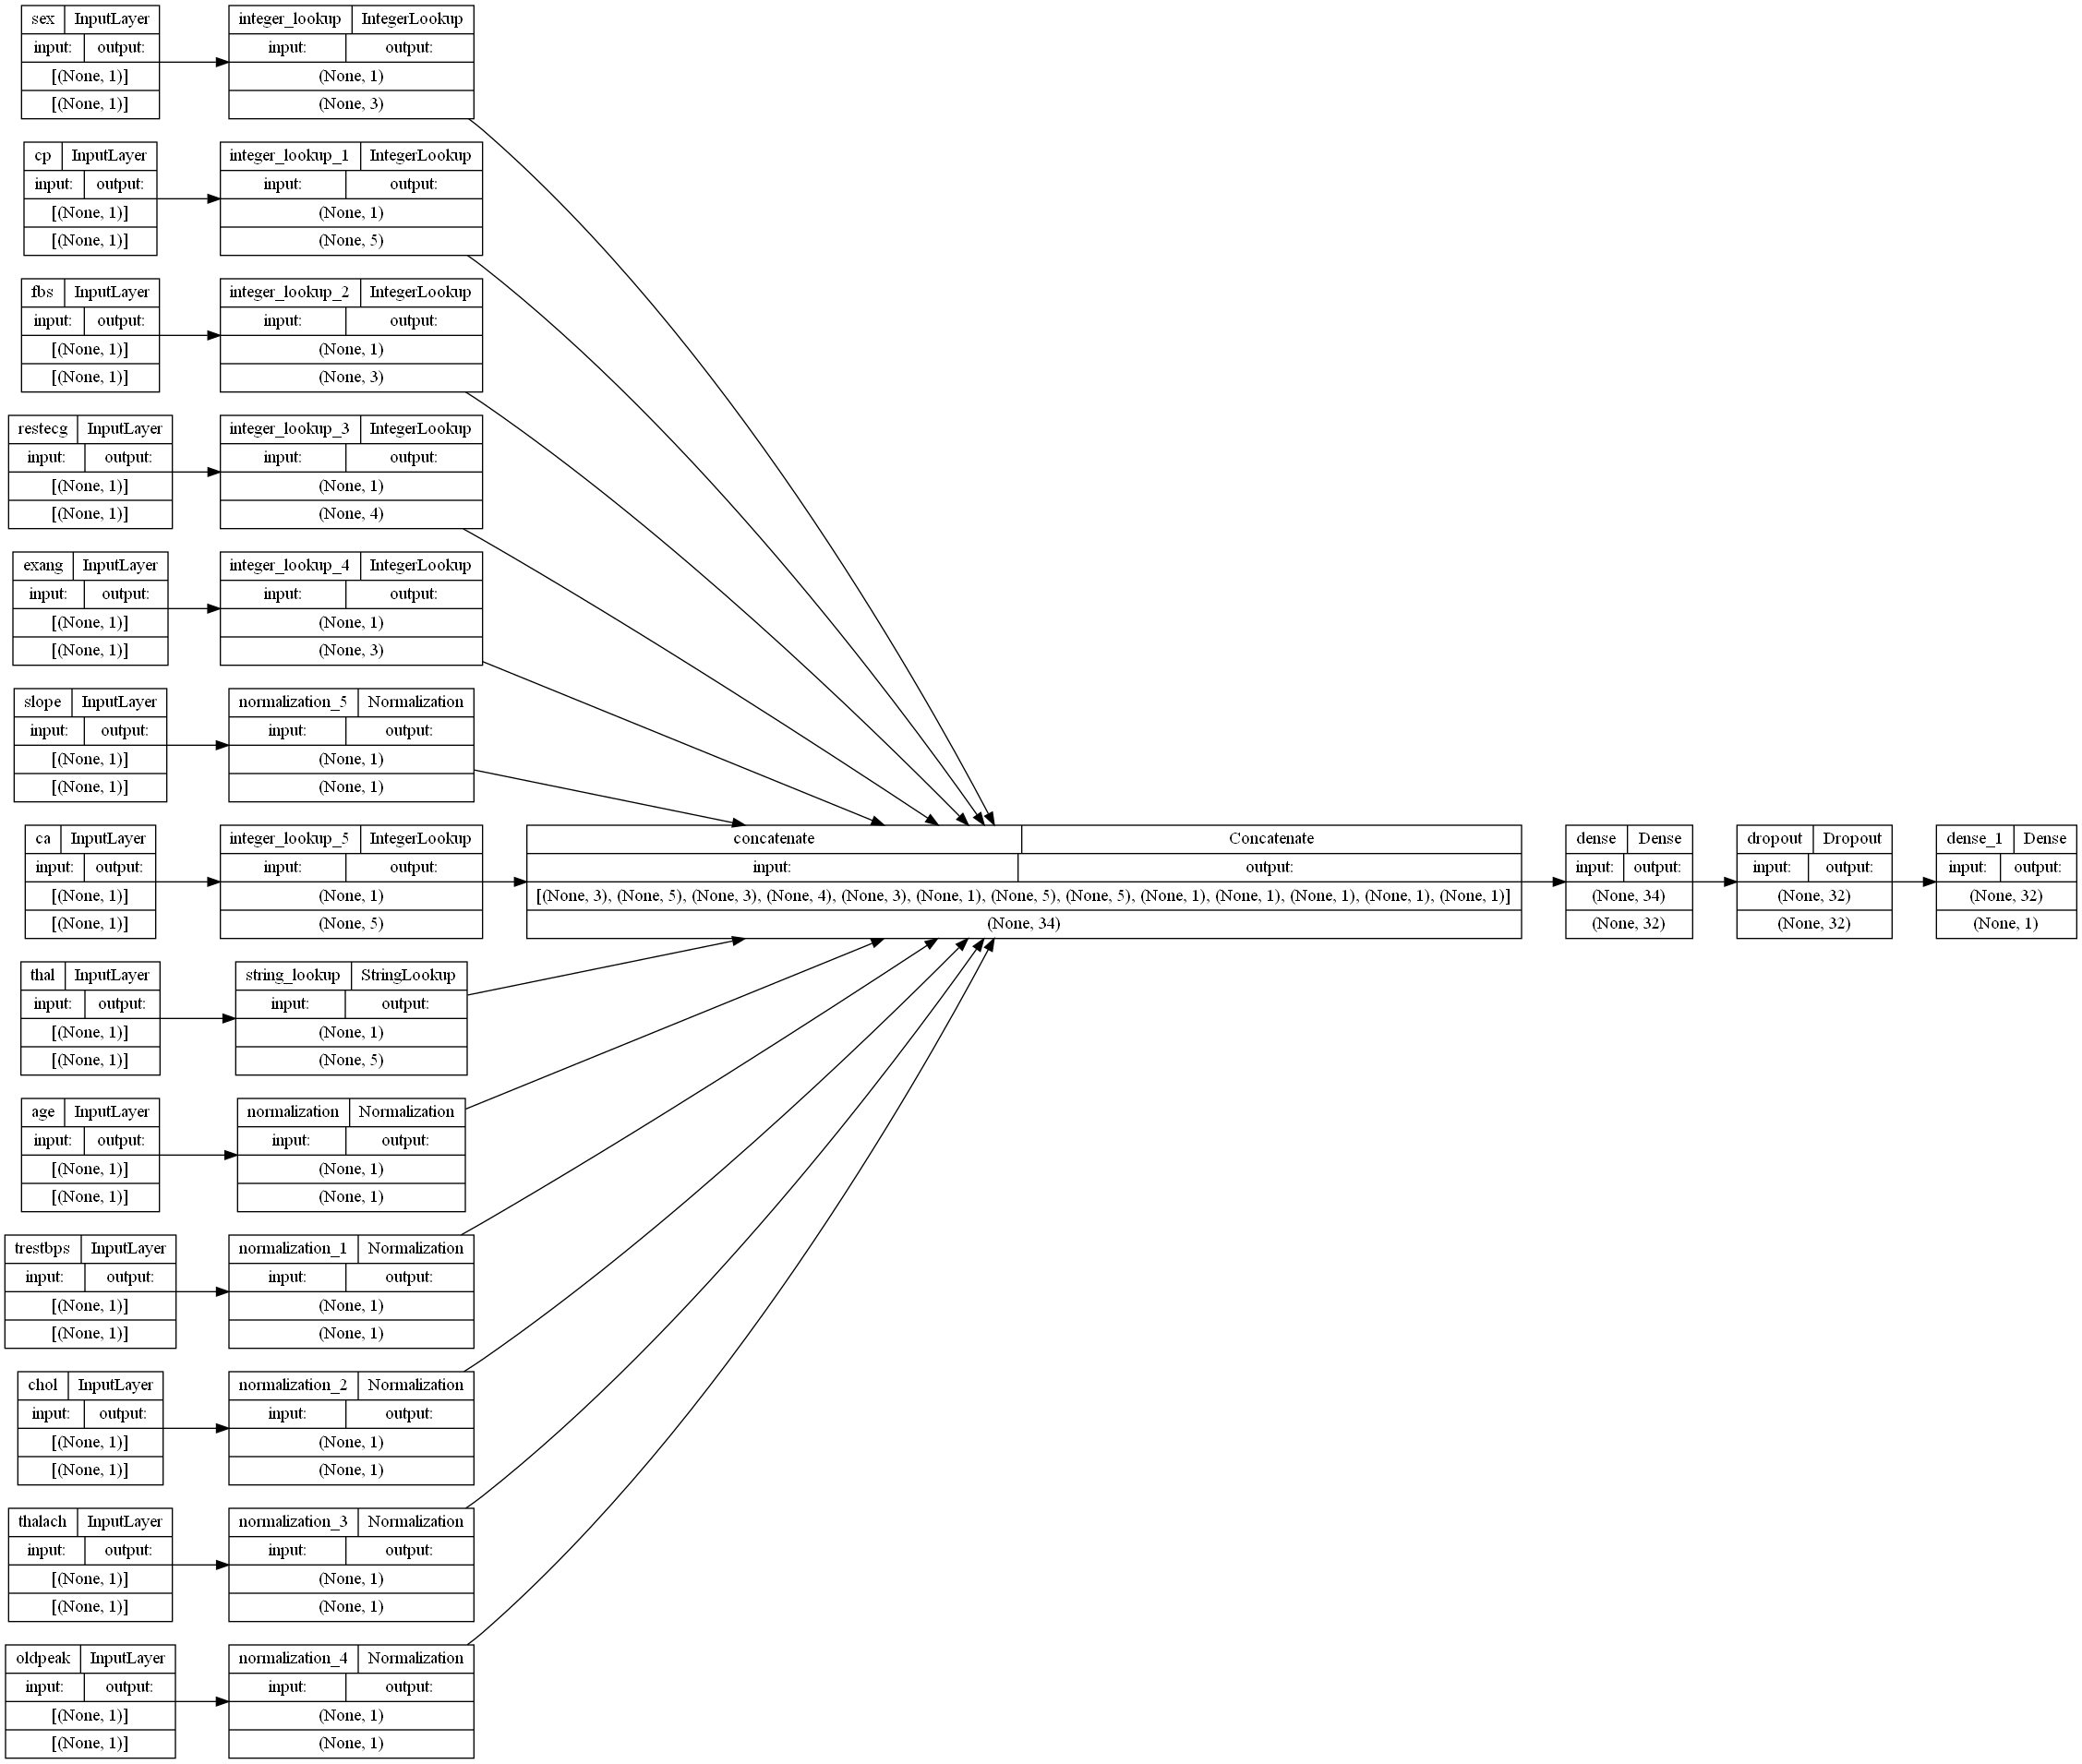

In [11]:
keras.utils.plot_model(modelo, show_shapes=True, rankdir="LR")

Com o modelo devidamente configurado para receber os dados de treino informaos à ele:

 - **`x`**: dados de treino do modelo, por utilizarmos um objeto do tipo `tf.data.dataset` não precisamos informar a variável resposta `y` já que ela está incorporada em nosso dataset
 - **`epochs`**: número de iterações entre os dados que será executado pela rede neural, neste caso ela fará 20 iterações com dados diferentes entre cada uma para encontrar a máxima acurácia.
 - **`validation_data`**: dados de teste que rede neural irá utilizar para validar a acurácia do modelo à cada iteração (_epoch_).
 

In [17]:
modelo.fit(
    x=treino_ds,
    epochs=50, 
    validation_data=teste_ds)

Epoch 1/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4013 - accuracy: 0.8150 - val_loss: 0.4309 - val_accuracy: 0.7763
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.3948 - accuracy: 0.8150 - val_loss: 0.4251 - val_accuracy: 0.7632
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3709 - accuracy: 0.8326 - val_loss: 0.4201 - val_accuracy: 0.7632
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3816 - accuracy: 0.8150 - val_loss: 0.4162 - val_accuracy: 0.7632
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.3832 - accuracy: 0.7974 - val_loss: 0.4121 - val_accuracy: 0.7763
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3586 - accuracy: 0.8502 - val_loss: 0.4088 - val_accuracy: 0.7763
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.3648 - accuracy: 0.8458 - val_loss: 0.4073 - val_accuracy: 0.7895
Epoch 8/50
8/8 [==================

Ao final da execução o modelo chegou em **85,5%** de assertividade!

**Teste do modelo**

Utilizaremos como exemplo um paciente que sabemos que possui um problema do coração

In [13]:
dados[dados['target'] == 1].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
6,62,0,4,140,268,0,2,160,0,3.6,3,2,normal,1
8,63,1,4,130,254,0,2,147,0,1.4,2,1,reversible,1
12,56,1,3,130,256,1,2,142,1,0.6,2,1,fixed,1
23,58,1,3,132,224,0,2,173,0,3.2,1,2,reversible,1


A rede neural não indica se a pessoa terá ou não um problema cardíaco, mas sim a probabilidade de ela possuir este problema.

In [21]:

teste = dados.iloc[[1]].drop("target", axis=1).to_dict('records')[0]

input_dict = {
    name: tf.convert_to_tensor([value]) for name, 
    value in teste.items()
}
    
predicao = modelo.predict(input_dict)

print(
    "Esta pessoa possui uma probabilidade de %.1f porcento de ter um problema do coração de acordo com o modelo" 
    % (100 * predicao[0][0],)
)

Esta pessoa possui uma probabilidade de 67.1 porcento de ter um problema do coração de acordo com o modelo


Pegando como base agora um paciente que sabemos que não possui problemas cardíacos, vemos que as chances de desenvolver algo sério de acordo com o modelo é de **`49,7%`**

In [15]:
dados[dados['target'] == 0].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,normal,0


In [19]:
teste = dados.iloc[[0]].drop("target", axis=1).to_dict('records')[0]

input_dict = {
    name: tf.convert_to_tensor([value]) for name, 
    value in teste.items()}
    
predicao = modelo.predict(input_dict)

print(
    "Esta pessoa possui uma probabilidade de %.1f porcento de ter um problema do coração de acordo com o modelo" 
    % (100 * predicao[0][0],)
)

Esta pessoa possui uma probabilidade de 69.9 porcento de ter um problema do coração de acordo com o modelo
